# 1_explore_full_dataset

In this notebook, we will use BigQuery to explore the entire [Natality dataset](https://console.cloud.google.com/bigquery?project=bigquery-public-data&p=publicdata&d=samples&t=natality&page=table) and use Pandas dataframe plot for visualization.

## Import necessary libraries & Set up environment variables 

In [4]:
import os
from google.cloud import bigquery

In [5]:
# for good-looking plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')
sns.set_context('talk')
#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
params = {'legend.fontsize': 12,
          'figure.figsize': (10, 5),
          'axes.labelsize': 12,
          'axes.titlesize':14,
          'xtick.labelsize':12,
          'ytick.labelsize':12}
plt.rcParams.update(params)

In [6]:
PROJECT = "predict-babyweight-10142021"
BUCKET = PROJECT
REGION = "us-central1"

os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET 
os.environ["REGION"] = REGION

In [ ]:
%%bash
if ! gsutil ls|grep -q gs://${BUCKET}/; then
    gsutil mb -l ${REGION} gs://${BUCKET}
fi

## Explore the dataset

Let's create a BigQuery client that we'll use throughout the notebook.

In [7]:
bq = bigquery.Client()

The Natality dataset is relatively large at almost 138 million rows and 31 columns. Let's get the list of all 31 column names in the natality dataset.

In [8]:
# Query to get all column names within table schema
query_colnames = """
SELECT
    column_name
FROM
    publicdata.samples.INFORMATION_SCHEMA.COLUMNS
WHERE
    table_name = "natality"
"""

# Send query through BigQuery client and store output to a dataframe
all_columns_df = bq.query(query_colnames).to_dataframe()

# Convert column names in dataframe to a list
all_columns = all_columns_df["column_name"].tolist()
print(all_columns)

['source_year', 'year', 'month', 'day', 'wday', 'state', 'is_male', 'child_race', 'weight_pounds', 'plurality', 'apgar_1min', 'apgar_5min', 'mother_residence_state', 'mother_race', 'mother_age', 'gestation_weeks', 'lmp', 'mother_married', 'mother_birth_state', 'cigarette_use', 'cigarettes_per_day', 'alcohol_use', 'drinks_per_week', 'weight_gain_pounds', 'born_alive_alive', 'born_alive_dead', 'born_dead', 'ever_born', 'father_race', 'father_age', 'record_weight']


The goal is to predict the baby's weight given a number of factors about the pregnancy and the baby's mother.  We should forcus the relevant columns only.

In [9]:
selected_columns =['weight_pounds','is_male','plurality','mother_age','gestation_weeks','cigarette_use','alcohol_use']

Now, let's view some of the values for the selected comlumns using BigQuery call with some added filterings:
* Only data for years later than `2002` (`cigarette_use` is available starting 2003)
* Only baby weights greater than `0`
* Only mothers whose age is greater than `0`
* Only plurality to be greater than `0`
* Only the number of weeks of gestation to be greater than `0`

In [10]:
concatenated_string=','.join(selected_columns)
query_2003= f"""
SELECT 
    {concatenated_string}
FROM
    publicdata.samples.natality
WHERE
    year > 2002
    AND weight_pounds > 0
    AND mother_age > 0
    AND plurality > 0
    AND gestation_weeks > 0
"""
df_limit_100 = bq.query(query_2003 + "LIMIT 100").to_dataframe()
df_limit_100.head()

,weight_pounds,is_male,plurality,mother_age,gestation_weeks,cigarette_use,alcohol_use
0,8.437091,False,1,22,41,False,False
1,9.404920,True,1,27,39,None,None
2,8.562754,True,1,35,39,None,None
3,8.187968,False,1,39,41,None,None
4,7.451624,False,1,41,40,False,False


Let's find how many records from the `query_2003`

In [11]:
    query_2003_count = f"SELECT COUNT(*) FROM ({query_2003})"
    df_count = bq.query(query_2003_count).to_dataframe()
    num_records = df_count['f0_'][0]
    print('*** Number of all records found:',num_records)

*** Number of all records found: 25037335


Let's write a query to find the unique values for each of the columns and the count of those values. Then, we 'll make bar plots to visualize those values.
This is important to ensure that we have enough examples of each data value, and to verify our hunch that the parameter has predictive value.

In [15]:
def get_distinct_values(column_name):
    """
    Gets Dataframe of distinct values, counts, and averages of BigQuery data column.
    """
    sql = f"""
    SELECT
    {column_name},
    COUNT(1) AS num_babies,
    AVG(weight_pounds) AS avg_wt
    FROM
    ({query_2003})
    GROUP BY
    {column_name}
    """
    return bq.query(sql).to_dataframe()

In [16]:
def plot_distinct_values(column_name):
    """
      Plots distinct value statistics of BigQuery data column.
    """
    df = get_distinct_values(column_name)
    df = df.sort_values(column_name)
    df.plot(x=column_name, y="num_babies", kind="bar", title=f"Number of babies vs. {column_name}", figsize=(12, 5))
    df.plot(x=column_name, y="avg_wt", kind="bar", title=f"Avarage babyweight vs. {column_name}", figsize=(12, 5))

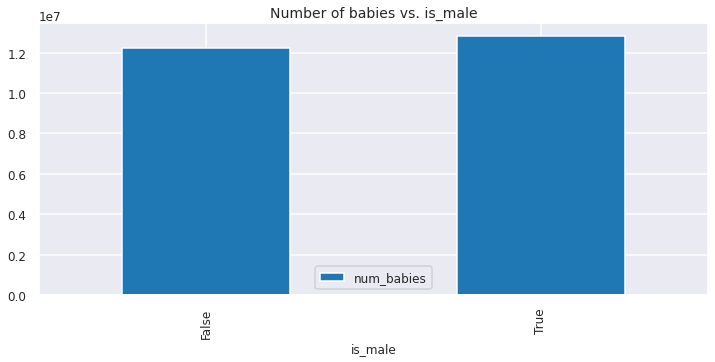

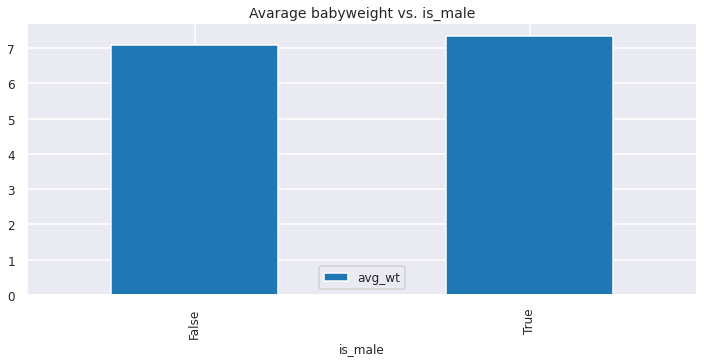

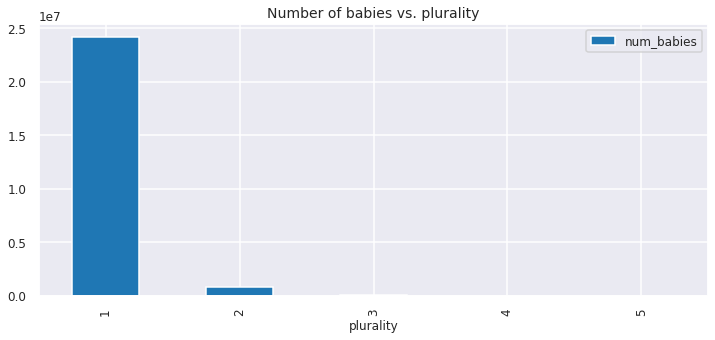

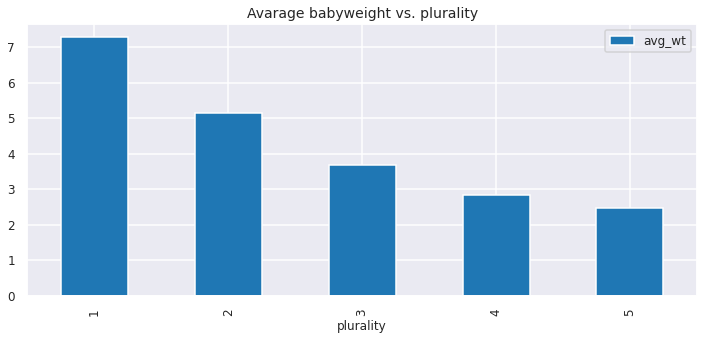

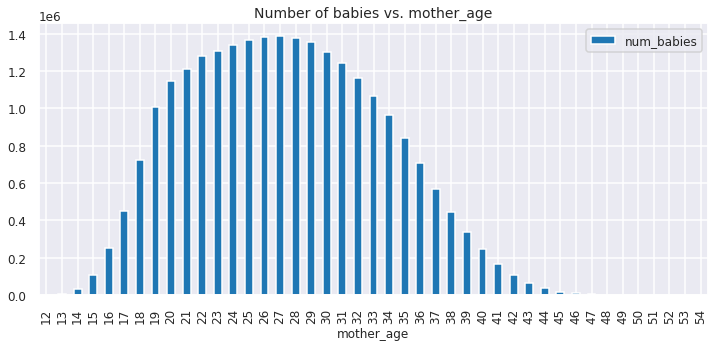

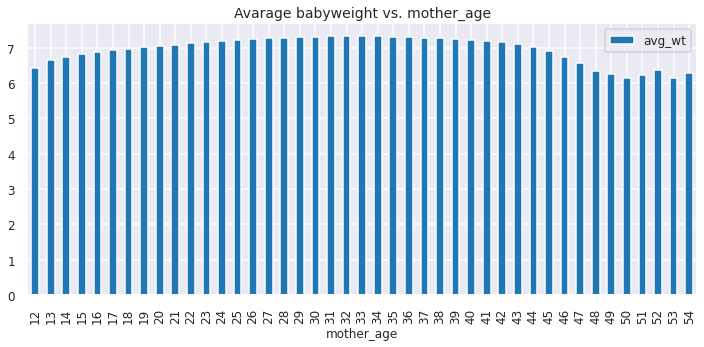

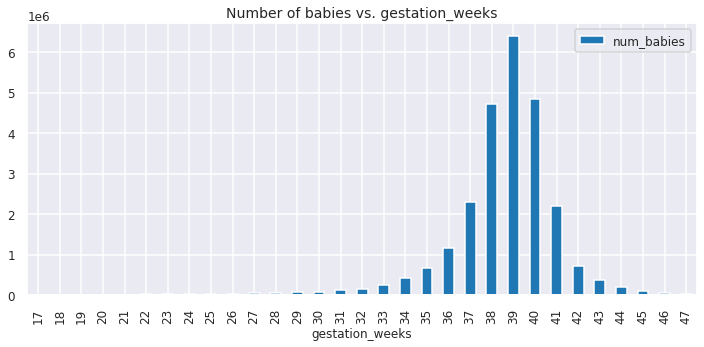

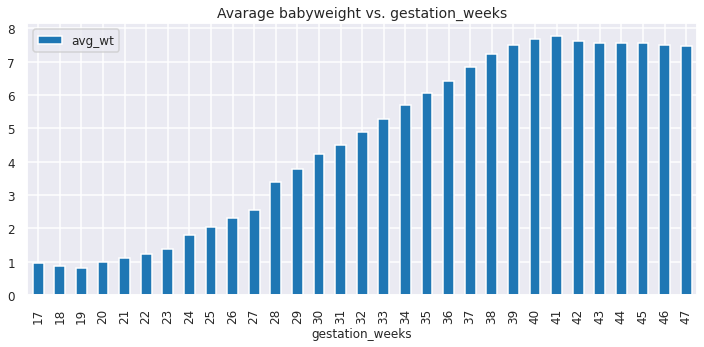

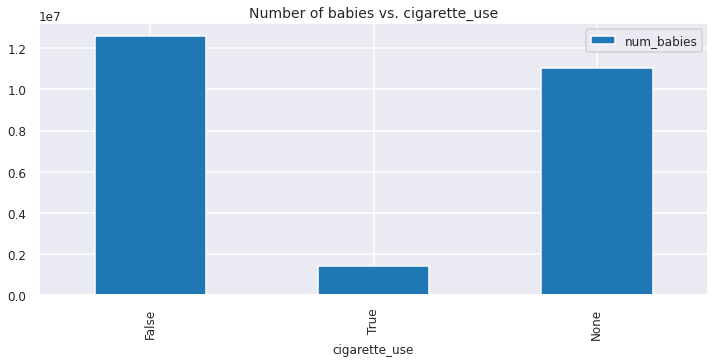

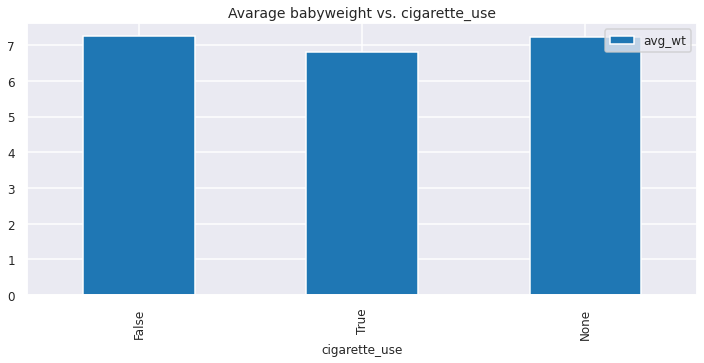

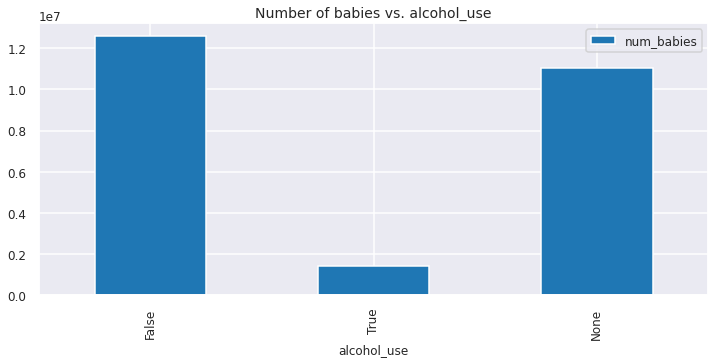

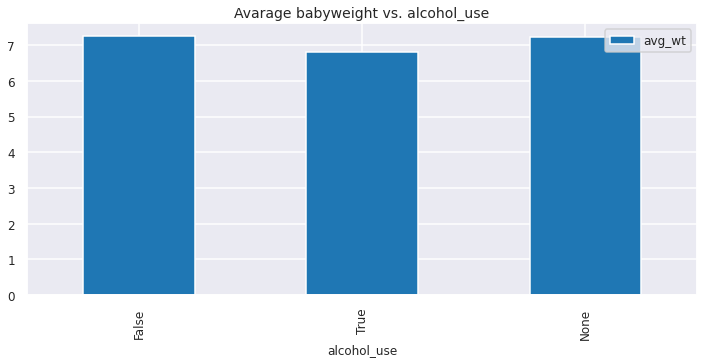

In [17]:
feature_columns = ['is_male','plurality','mother_age','gestation_weeks','cigarette_use','alcohol_use']
for column in feature_columns:
    plot_distinct_values(column)

## Summary:

- Using the query_2003 with the filtering year>2002, we got a new dataset with~25 milion records (number of babies). This dataset are big enough to ensure that we can use it to build a reliable model prediction.
- All these five selected factors (`plurality`,`mother_age`,`gestation_weeks`,`cigarette_use`,`alcohol_use`) seem to play a part in the baby's weight:
    - Male babies are heavier on average than female babies. 
    - Teenaged and older moms tend to have lower-weight babies. 
    - Twins, triplets, etc. are lower weight than single births. 
    - Preemies have lower weigh than the other. 
    - Moms in use of cigarret or alcohol have lower-weight babies.

In the next notebooks, `2_prototype_model.ipynb`, we will combine all of these factors in a small subsample of the dataset to develop a machine learning model locally for the prototyping purpose.